In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import string
from scipy import stats
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import GammaRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import Lasso

from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from wordcloud import WordCloud, STOPWORDS
from dataprep.clean import clean_df
from sklearn.metrics import r2_score


In [2]:
listingsDir = os.path.abspath('../Data/listings.csv')
reviewsDir = os.path.abspath('../Data/reviews.csv')
listings = pd.read_csv(listingsDir)
reviews = pd.read_csv(reviewsDir)
listings = pd.DataFrame(listings)
df = pd.DataFrame()
response_time = listings.host_response_time
response_time.fillna("within a day", inplace=True)
response_rate = listings.host_response_rate
response_rate.fillna("100%", inplace=True)
is_superhost = listings.host_is_superhost
is_superhost.fillna("f", inplace=True)
listings_count = listings.host_listings_count
is_superhost.fillna(1, inplace=True)
total_listings_count = listings.host_total_listings_count
is_superhost.fillna(1, inplace=True)
property_type = listings.property_type
is_superhost.fillna("Private room in home", inplace=True)

price = listings.price
price = price.str.replace('$', '')
price = price.str.replace(',', '')
price = price.fillna(100.0).astype(float)
price = price.astype(int)
response_rate = response_rate.str.rstrip("%")
response_rate = response_rate.fillna(94).astype(int) #replace nan with mean 94
df_y = pd.DataFrame(listings.review_scores_communication)
df_y.index=listings.id
df_y = df_y.fillna(df_y.mean())

df_features = pd.concat([listings.id,response_rate, is_superhost, response_time, listings_count,total_listings_count, price], axis=1)
df_features.set_index(["id"], inplace=True)
df_dummies = df_features[df_features.columns[2:3]]
df_rest = df_features.drop(["host_is_superhost","host_response_time"], axis =1)
df_dummies=pd.get_dummies(df_dummies)
df_rest_scal=StandardScaler().fit_transform(df_rest)
df_trans = pd.DataFrame(df_rest_scal, index=df_rest.index, columns=df_rest.columns)
df = pd.merge(df_trans, df_dummies, how='inner', on = 'id')
df = pd.merge(df, df_y, how='inner', on = 'id')
df_y = pd.DataFrame(df.review_scores_communication, index=df.index)
df_x = df.drop("review_scores_communication", axis =1)
x = df_x
y = df_y

C:\Users\Cormac\AppData\Local\Temp\ipykernel_33720\3165946413.py:21: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  price = price.str.replace('$', '')


In [3]:
#model = LinearRegression()
#model = PoissonRegressor()
#model = TweedieRegressor()
#model = GammaRegressor() # struggles with 0 values
#model = DummyRegressor(strategy="mean")
#model = Ridge(alpha=1/(2*100))
#model = Lasso(alpha=1/(2*100))
model = RandomForestRegressor(n_estimators = 10, max_depth=8, random_state = 0)
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=4)


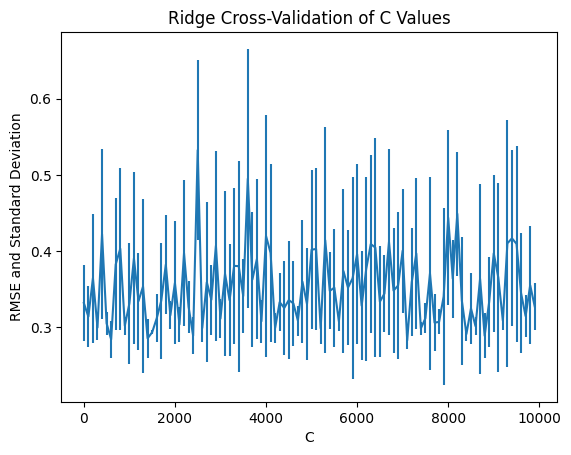

In [4]:
C = range(1,10000,100)
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y)
std_error = []
mean_error = []
for Ci in C:
    temp = []
    kf = KFold(n_splits=4)
    for i in range(0,5):
        x_train, x_test, y_train, y_test = train_test_split(df_x, df_y)
        model = Ridge(alpha=1/(2*Ci))
        model.fit(x_train,y_train)
        #print("\nC value: "+str(Ci))
        #print("Lasso coef: "+str(model.coef_))
        #print("Lasso intercept: "+str(model.intercept_))
        y_pred = model.predict(x_test)
        msqe = mean_squared_error(y_test,y_pred,squared = False)
        temp.append(msqe)
    #print("root_mean_squared error of is = ",msqe)
    mean_error.append(np.array(temp).mean())
    std_error.append(np.array(temp).std())


plt.figure(dpi=100)
plt.errorbar(C,mean_error,yerr=std_error)
plt.xlabel('C'); plt.ylabel('RMSE and Standard Deviation')
plt.title('Ridge Cross-Validation of C Values')
plt.show()

In [5]:
model.fit(x_train,y_train)

Ridge(alpha=5.04999495000505e-05)

In [6]:
#Predict unseen data
y_pred = model.predict(x_test)
scores = cross_val_score(model, x_test, y_test, cv=4 ,scoring='neg_root_mean_squared_error')
r2 = cross_val_score(model, x_test, y_test, cv=4 ,scoring='r2')
#scores = model.score(x_test_fit, y_test+0.01)
print(model)
print("\nRoot Mean Square Error: ",-scores.mean())
print("\nMean Square Error: ",scores.mean()**2)
print("\nStandard Deviation: ", scores.std())
print("\nR2: ", r2.mean())

Ridge(alpha=5.04999495000505e-05)

Root Mean Square Error:  0.28741630492347486

Mean Square Error:  0.08260813233586388

Standard Deviation:  0.08547803976917404

R2:  -0.011849005087230552
